In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

2023-10-27 13:18:42.971625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# df = pd.read_csv("./ml-latest-small/ratings.csv")
df = pd.read_csv("../data/user_rating.csv")
df.shape

(996961, 3)

In [12]:
# Group the DataFrame by 'user_id' and count the number of ratings
user_ratings_count = df['user_id'].value_counts()

# Get the top 1000 users with the most ratings
top_1000_users = user_ratings_count.head(500).reset_index()
top_1000_users.columns = ['user_id', 'num_ratings']

# Filter the original DataFrame to include only the top 1000 users
df = df[df['user_id'].isin(top_1000_users['user_id'])]

In [13]:
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 500, Number of Movies: 70790, Min rating: 1.0, Max rating: 10.0


In [14]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [20]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


if tf.config.list_physical_devices('GPU'):
    model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
    )

In [21]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
3916/3916 [==============================] - 115s 29ms/step - loss: 0.6613 - val_loss: 0.6620
Epoch 2/5
3916/3916 [==============================] - 120s 31ms/step - loss: 0.6555 - val_loss: 0.6600
Epoch 3/5
3916/3916 [==============================] - 111s 28ms/step - loss: 0.6526 - val_loss: 0.6599
Epoch 4/5
3916/3916 [==============================] - 118s 30ms/step - loss: 0.6495 - val_loss: 0.6595
Epoch 5/5
3916/3916 [==============================] - 108s 28ms/step - loss: 0.6472 - val_loss: 0.6588


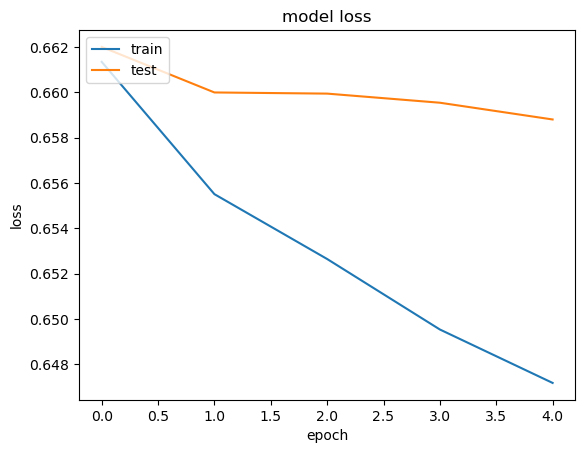

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [29]:
# movie_df = pd.read_csv("./ml-latest-small/movies.csv")
movie_df = pd.read_csv("../preprocessed_data/movies_data.csv")

# Let us get a user and see the top recommendations.
user_id = df.user_id.sample(1).iloc[0]
movies_watched_by_user = df[df.user_id == user_id]
movies_not_watched = movie_df[
    ~movie_df["movie_id"].isin(movies_watched_by_user.movie_id.values)
]["movie_id"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movie_id.values
)
movie_df_rows = movie_df[movie_df["movie_id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movie_id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

/tmp/ipykernel_38911/2101198824.py:2: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_df = pd.read_csv("../preprocessed_data/movies_data.csv")


486/486 [==============================] - 1s 2ms/step
Showing recommendations for user: ur1606763
Movies with high ratings from user
--------------------------------
--------------------------------
Top 10 movie recommendations
--------------------------------
Amadeus : Biography,Drama,Music
Planet of the Apes : Adventure,Sci-Fi
The Father : Drama,Mystery
Room : Drama,Thriller
The Grapes of Wrath : Drama
Ben-Hur : Adventure,Drama
Ratatouille : Animation,Adventure,Comedy
Some Like It Hot : Comedy,Music,Romance
Witness for the Prosecution : Crime,Drama,Mystery
Sunset Blvd. : Drama,Film-Noir
